In [10]:
from plotly_calplot import calplot

from common.explore import display_sql

In [11]:
display_sql(f'''
CREATE OR REPLACE VIEW test_changelog AS
WITH
   normalized_with_previous AS (
    SELECT job_id,
           location_name,
           company_name,
           technology_name,
           online_at,
           online_at - INTERVAL 1 DAY AS previous_day
      FROM normalized_online_job_months_3
     --WHERE online_at >= current_date - INTERVAL 30 DAY
), min_online_at AS (
    SELECT MIN(online_at)
      FROM normalized_with_previous
), max_online_at AS (
    SELECT MAX(online_at)
      FROM normalized_with_previous
), joined_normalized_with_previous AS (
    SELECT DISTINCT
           c.job_id,
           c.online_at,
           c.location_name,
           c.company_name,
           c.technology_name,
           p.location_name AS previous_location_name,
           p.company_name AS previous_company_name,
           p.technology_name AS previous_technology_name,
           p.online_at AS previous_online_at,
           p.job_id AS previous_job_id
      FROM normalized_with_previous c
      FULL OUTER JOIN normalized_with_previous p
        ON (c.job_id = p.job_id AND
            c.location_name = p.location_name AND
            c.company_name = p.company_name AND
            c.technology_name = p.technology_name AND
            c.previous_day = p.online_at)
)
SELECT previous_job_id AS job_id,
       previous_location_name AS location_name,
       previous_company_name AS company_name,
       previous_technology_name AS technology_name,
       (previous_online_at + INTERVAL 1 DAY) AS online_at,
       'deleted' AS change
  FROM joined_normalized_with_previous
 WHERE job_id IS NULL
   AND previous_online_at NOT IN (SELECT * FROM max_online_at)
UNION ALL
SELECT job_id,
       location_name,
       company_name,
       technology_name,
       online_at,
       'added' AS change
  FROM joined_normalized_with_previous
 WHERE previous_job_id IS NULL
   AND online_at NOT IN (SELECT * FROM min_online_at)
''', read_only=False)

,Count


In [12]:
df = display_sql(f'''
SELECT online_at,
       change,
       COUNT(DISTINCT ob_id)
  FROM test_changelog
 GROUP BY 1, 2
 ORDER BY 1, 2
''')
df

,online_at,change,count(DISTINCT job_id)
0,2022-07-22,added,3994
1,2022-07-22,deleted,3529
2,2022-07-23,added,1185
3,2022-07-23,deleted,5150
4,2022-07-24,added,241
...,...,...,...
177,2022-10-18,deleted,3154
178,2022-10-19,added,3850
179,2022-10-19,deleted,1732
180,2022-10-20,added,5169


In [13]:
df = display_sql(f'''
SELECT online_at,
       COUNT(*) AS added
  FROM test_changelog
 WHERE change = 'added'
 GROUP BY 1
 ORDER BY 1
''')
df

,online_at,added
0,2022-07-22,6272
1,2022-07-23,1622
2,2022-07-24,363
3,2022-07-25,5149
4,2022-07-26,6355
...,...,...
86,2022-10-16,773
87,2022-10-17,5424
88,2022-10-18,6480
89,2022-10-19,5871


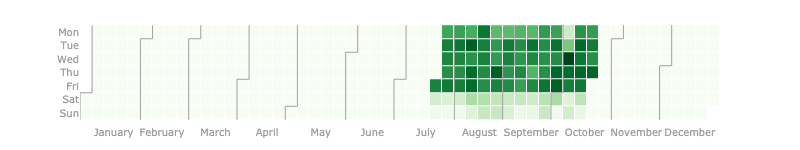

In [14]:
fig = calplot(
    df,
    x='online_at',
    y='added',
    colorscale='Greens'
)
fig.show('png')

In [15]:
df = display_sql(f'''
SELECT online_at,
       COUNT(*) AS deleted
  FROM test_changelog
 WHERE change = 'deleted'
 GROUP BY 1
 ORDER BY 1
''')
df

,online_at,deleted
0,2022-07-22,4949
1,2022-07-23,7011
2,2022-07-24,6162
3,2022-07-25,5575
4,2022-07-26,5695
...,...,...
86,2022-10-16,5373
87,2022-10-17,4632
88,2022-10-18,4519
89,2022-10-19,3380


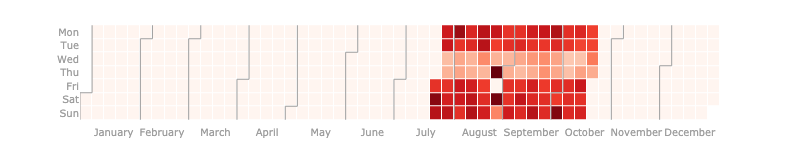

In [16]:
fig = calplot(
    df,
    x='online_at',
    y='deleted',
    colorscale='Reds'
)
fig.show('png')

In [17]:
display_sql(f'''
DROP VIEW test_changelog
''', read_only=False)

,Success
